In [2]:
# %load validation.py
import math

import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
df = pd.read_csv("./data/california_housing_train.csv", sep=",")
df["target"] = df["median_house_value"] / 1000
df.describe()

# 1. Define target and features
# - Define features and configure feature columns
# - Define the target
# - Define the input function.

# 2. Define the model
# - Configure the linear regression
# - Train the model

# 3. Evalute the model.
# - Predict
# - Measure score.


def preprcoess_features(src_df, feature_labels):
    df = src_df[feature_labels].copy()
    return df


def preprocess_target(src_df, target_label):
    df = pd.DataFrame()
    df['target'] = src_df[target_label] / 1000.0
    return df


def get_feature_columns(feature_labels):
    return set([
        tf.feature_column.numeric_column(feature_label)
        for feature_label in feature_labels
    ])


# get_feature_columns(feature_labels)


def input_fn(X_data,
             y_data,
             batch_size=1,
             repeat=1,
             shuffle=False):
    X_tensor = {key: np.array(value) for key, value in dict(X_data).items()}
    y_tensor = y_data
    ds = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))
    ds = ds.batch(int(batch_size)).repeat(repeat)
    if shuffle:
        ds = ds.shuffle(10000)
    X, y = ds.make_one_shot_iterator().get_next()
    return X, y


def train_model(hidden_units=[3],
                learning_rate=1e-4,
                steps=10,
                batch_size=1,
                feature_labels=['population'],
                target_label='median_house_value',
                repeat=1):

    # hidden_units=[3]
    # learning_rate=1e-4
    # steps=10000
    # batch_size=100
    # feature_labels=['population']
    # target_label='median_house_value'
    # repeat=None

    periods = 10
    steps_per_period = steps / periods

    print('steps', steps)
    print('batch_size', batch_size)
    print('steps_per_period', steps_per_period)

    X_train = preprcoess_features(df.head(12000), feature_labels)
    y_train = preprocess_target(df.head(12000), target_label)

    X_valid = preprcoess_features(df.tail(5000), feature_labels)
    y_valid = preprocess_target(df.tail(5000), target_label)

    train_input_fn = lambda: input_fn(X_train, y_train, batch_size=batch_size, repeat=repeat, shuffle=True)
    predict_train_input_fn = lambda: input_fn(X_train, y_train, batch_size=1, repeat=1, shuffle=False)
    predict_valid_input_fn = lambda: input_fn(X_valid, y_valid, batch_size=1, repeat=1, shuffle=False)

    # Define the model
    # - configure liner regression
    #   - configure optimizer
    #   - choose algorithmn
    # - train the model

    gopt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    gopt = tf.contrib.estimator.clip_gradients_by_norm(gopt, 5.0)

    dnn_regressor = tf.estimator.DNNRegressor(
        hidden_units=hidden_units,
        feature_columns=get_feature_columns(feature_labels),
        optimizer=gopt)

    train_RMSEs = []
    valid_RMSEs = []

    for period in range(0, periods):
        dnn_regressor.train(input_fn=train_input_fn, steps=steps_per_period)

        train_predictions = dnn_regressor.predict(
            input_fn=predict_train_input_fn)
        train_predictions = [
            item['predictions'][0] for item in train_predictions
        ]
        train_mean_squared_error = metrics.mean_squared_error(
            y_train, train_predictions)
        train_RMSE = math.sqrt(train_mean_squared_error)
        train_RMSEs.append(train_RMSE)

        valid_predictions = dnn_regressor.predict(
            input_fn=predict_valid_input_fn)
        valid_predictions = [
            item['predictions'][0] for item in valid_predictions
        ]
        valid_mean_squard_error = metrics.mean_squared_error(
            y_valid, valid_predictions)
        valid_RMSE = math.sqrt(valid_mean_squard_error)
        valid_RMSEs.append(valid_RMSE)

        print("period %02d: t: %0.2f v: %0.2f" % (period, train_RMSE,
                                                  valid_RMSE))

    plt.subplot(1, 2, 1)
    plt.xlabel('Periods')
    plt.ylabel('train_RMSE')
    plt.plot(np.arange(len(train_RMSEs)), train_RMSEs)

    plt.subplot(1, 2, 2)
    plt.xlabel('Periods')
    plt.ylabel('valid_RMSE')
    plt.plot(np.arange(len(valid_RMSEs)), valid_RMSEs)

    print('train_result_df')
    train_result_df = pd.DataFrame({
        "train_prediction":
        pd.Series(train_predictions),
        "target":
        df["target"]
    })
    print(train_result_df.describe())

    print('valid_result_df')
    valid_result_df = pd.DataFrame({
        "valid_prediction":
        pd.Series(valid_predictions),
        "target":
        df["target"]
    })
    print(valid_result_df.describe())
    print("RMSE t: %0.2f v: %0.df" % (train_RMSE, valid_RMSE))

    plt.show()


train_model(
    hidden_units=[1],
    learning_rate=1e-4,
    steps=2e+4,
    batch_size=100,
    feature_labels=['population'],
    repeat=None
)


steps 20000.0
batch_size 100
steps_per_period 2000.0
period 00: t: 226.57 v: 259.30
period 01: t: 225.70 v: 258.42
period 02: t: 224.83 v: 257.54
period 03: t: 223.97 v: 256.66
period 04: t: 223.10 v: 255.78
period 05: t: 222.24 v: 254.90
period 06: t: 221.37 v: 254.02
period 07: t: 220.51 v: 253.15
period 08: t: 219.65 v: 252.27
period 09: t: 218.79 v: 251.40
train_result_df
             target  train_prediction
count  17000.000000      12000.000000
mean     207.300912         10.000319
std      115.983764          0.000000
min       14.999000         10.000319
25%      119.400000         10.000319
50%      180.400000         10.000319
75%      265.000000         10.000319
max      500.001000         10.000319
valid_result_df
             target  valid_prediction
count  17000.000000       5000.000000
mean     207.300912         10.000319
std      115.983764          0.000000
min       14.999000         10.000319
25%      119.400000         10.000319
50%      180.400000         10.0003

<Figure size 640x480 with 2 Axes>

In [3]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

steps 20000.0
batch_size 100
steps_per_period 2000.0
period 00: t: 168.61 v: 192.76
period 01: t: 168.75 v: 195.23
period 02: t: 168.88 v: 191.74
period 03: t: 168.55 v: 193.83
period 04: t: 168.66 v: 192.39
period 05: t: 168.54 v: 193.56
period 06: t: 168.75 v: 195.26
period 07: t: 168.59 v: 192.72
period 08: t: 168.65 v: 192.40
period 09: t: 168.57 v: 192.80
train_result_df
       target  train_prediction
count 17000.0           12000.0
mean    207.3             122.5
std     116.0              97.4
min      15.0               0.3
25%     119.4              67.7
50%     180.4             100.2
75%     265.0             147.5
max     500.0            2961.2
valid_result_df
       target  valid_prediction
count 17000.0            5000.0
mean    207.3             109.4
std     116.0              89.1
min      15.0               0.7
25%     119.4              60.7
50%     180.4              89.2
75%     265.0             132.0
max     500.0            2370.6
RMSE t: 168.57 v: 192f


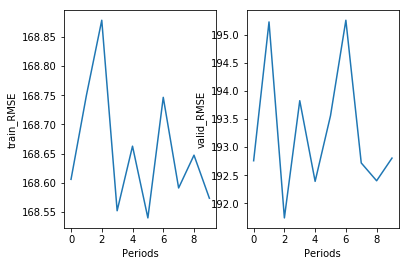

In [4]:
train_model(
    hidden_units=[3],
    learning_rate=1e-4,
    steps=2e+4,
    batch_size=100,
    feature_labels=['population'],
    repeat=None
)

In [ ]:
train_model(
    hidden_units=[3],
    learning_rate=1e-4,
    steps=2e+4,
    batch_size=100,
    feature_labels=['population'],
    repeat=None
)